In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib notebook

from time import time

# #1

In [2]:
def secondOrderPoly(x,pars):
    a,b,c = pars
    return a*x**2 + b*x + c
def lorentz(x,pars):
    return 1/(1-x**2)
def gaussian(x,pars):
    return np.exp(-0.5*x**2)

def simple_integrate( fun,pars,a,b , tol , total_recur_calls , max_recur_calls=10 ):
    x=np.linspace(a,b,5)
    dx=(b-a)/(5-1)
    y=fun(x,pars)
    neval=len(x) #let's keep track of function evaluations
    f1=(y[0]+4*y[2]+y[4])/6.0*(b-a)
    f2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/12.0*(b-a)
    myerr=np.abs(f2-f1)
    #print([a,b,f1,f2])
    total_recur_calls += 1
    if (myerr<tol) or total_recur_calls > max_recur_calls:
        #return (f2)/1.0,myerr,neval
        return (16.0*f2-f1)/15.0,myerr,neval
    else:
        mid=0.5*(b+a)
        f_left,err_left,neval_left=simple_integrate(fun,pars,a,mid,tol/2.0 , total_recur_calls)
        f_right,err_right,neval_right=simple_integrate(fun,pars,mid,b,tol/2.0 , total_recur_calls)
        neval=neval+neval_left+neval_right
        f=f_left+f_right
        err=err_left+err_right
        return f,err,neval

    # The idea behind this is to simply store the function evals we have completed so far
def tracker_integrate( fun,pars,a,b , tol , total_recur_calls , track_x=[],track_y=[] , max_recur_calls=10):
    
    x=np.linspace(a,b,5); y = np.empty(len(x))
    dx=(b-a)/(5-1)
    neval = 0
    for i in range(len(x)):
        if np.any(x[i]==np.array(track_x)):
            y[i] = track_y[track_x.index(x[i])]
        else:
            y[i] = fun(x[i],pars); neval += 1
            track_x.append(x[i]);  track_y.append(y[i])
            
    f1=(y[0]+4*y[2]+y[4])/6.0*(b-a)
    f2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/12.0*(b-a)
    myerr=np.abs(f2-f1)
    #print([a,b,f1,f2])
    total_recur_calls += 1
    
    if (myerr<tol) or total_recur_calls > 10:
        return (16.0*f2-f1)/15.0,myerr,neval
    else:
        mid=0.5*(b+a)
        f_left , err_left , neval_left = tracker_integrate(fun,pars,a,mid,tol/2.0 , total_recur_calls , track_x,track_y)
        f_right , err_right , neval_right = tracker_integrate(fun,pars,mid,b,tol/2.0 , total_recur_calls , track_x,track_y)
        neval += neval + neval_left + neval_right
        f = f_left + f_right
        err = err_left + err_right
        return f , err  ,neval



In [3]:
a=2 ; b=3 ; c=4
pars = (a,b,c)
x_left=-5 ; x_right=5
tol = 10**-6

funcs = [secondOrderPoly,lorentz,gaussian]
fnames = ['secondOrderPoly','lorentzian','gaussian']
for i in range(len(funcs)):
    t0 = time()
    f , err , neval = simple_integrate( funcs[i],pars , x_left,x_right , tol , 0 )
    t1 = time()
    F , ERR , NEVAL = tracker_integrate( funcs[i],pars , x_left,x_right , tol , 0 , track_x=[],track_y=[])
    t2 = time()
    print('Function evals for',fnames[i],'using naive approach:',neval,'    Took',t1-t0,'secs')
    print('Function evals for',fnames[i],'using bestest approach:',NEVAL,'  Took',t2-t1,'secs')
    print('')

Function evals for secondOrderPoly using naive approach: 5     Took 0.0 secs
Function evals for secondOrderPoly using bestest approach: 5   Took 0.0 secs

Function evals for lorentzian using naive approach: 2815     Took 0.05982494354248047 secs
Function evals for lorentzian using bestest approach: 1694   Took 0.5340244770050049 secs

Function evals for gaussian using naive approach: 795     Took 0.01599407196044922 secs
Function evals for gaussian using bestest approach: 482   Took 0.07212686538696289 secs



# #2

## **a)**

In [4]:
# taken from cheb_expand.py from prof Sievers
def cheb_mat_uniform( nx , orda ):
    x = np.linspace(-1,1,nx)
    mat=np.zeros([nx,orda+1])
    mat[:,0]=1.0
    if orda>0:
        mat[:,1]=x
    if orda>1:
        for i in range(1,orda):
            mat[:,i+1]=2*x*mat[:,i]-mat[:,i-1]
    return mat

For 10th order cheby truncated after 8 terms, rms error is  1.9192926985792155e-07  , max error  3.211746508746671e-07
For 7th order Legendre polyfit,               rms error is  1.6852518243629313e-07  , max error  7.888699755653761e-07


<IPython.core.display.Javascript object>


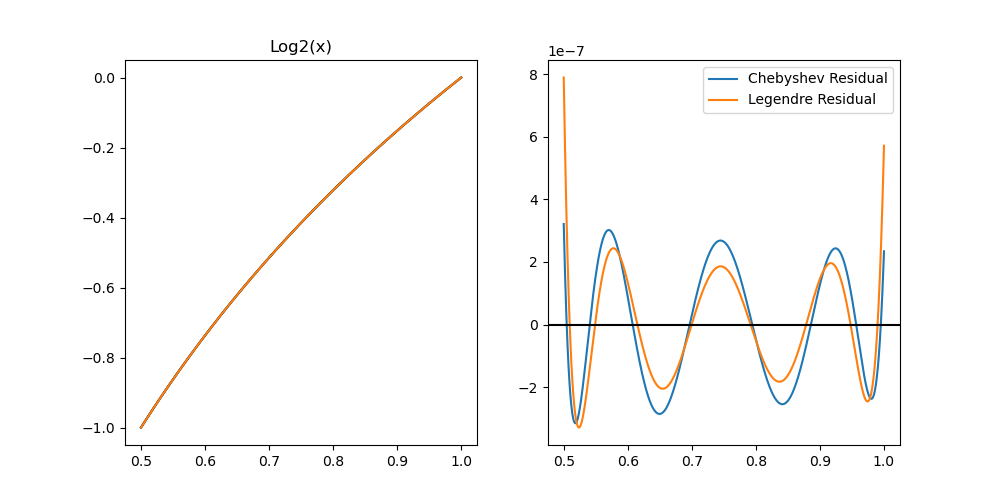

In [5]:
# number of points 
n=1000
# 'worse_accuracy' will track the highest error in our fit
# ncoeff will track the amount of terms needed to obtain our desired accuracy
orda = 10;   desired_accuracy=10**-6;   worse_accuracy = 1;   ncoeff = 1
x_left = 0.5 ;   x_right = 1

    # Since we are using a linspace, rescaling the values to (-1,1) can be done
    # simply by retaining the length of the original array and creating a np.linspace
    # with it and the correct cheby bounds
mat=cheb_mat_uniform(n,orda)
x = np.linspace(x_left,x_right,n)
y=np.log2(x)
    
    # Taken from Prof. Sievers' 'cheb_expand.py'
    # Performs least-squares fit
lhs=np.dot(mat.transpose(),mat)
rhs=np.dot(mat.transpose(),y)
fitp=np.dot(np.linalg.inv(lhs),rhs)

    # increment ncoeff until desired accuracy is obtained, or max number of terms reached
while (worse_accuracy >= desired_accuracy and ncoeff <= orda+1):
    y_cheb = np.dot(mat[:,:ncoeff],fitp[:ncoeff])
    worse_accuracy = np.max(np.abs(y_cheb-y))
    ncoeff += 1
ncoeff -= 1

    # Need to supply ncoeff-1 to this routine since it asks for the max degree and not the number of coefficients
leg_co = np.polynomial.legendre.legfit(x,y,ncoeff-1)    
y_leg = np.polynomial.legendre.legval(x,leg_co)

print( 'For '+str(orda)+'th order cheby truncated after',ncoeff,'terms, rms error is ',np.sqrt(np.mean((y_cheb-y)**2)),' , max error ',worse_accuracy )
print( 'For '+str(ncoeff-1)+'th order Legendre polyfit,               rms error is ',np.sqrt(np.mean((y_leg-y)**2)),' , max error ',np.max(np.abs(y_leg-y)) )
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title('Log2(x)'); plt.plot(x,y_cheb); plt.plot(x,y,c='black'); plt.plot(x,y_leg)
plt.subplot(1,2,2); plt.plot(x,y_cheb-y); plt.plot(x,y_leg-y); plt.axhline(0,c='black')
plt.legend(['Chebyshev Residual','Legendre Residual'])

**We could observe that a truncation including 8 terms in the Chebyshev series gives the desired maximum error in our fit. We therefore need at least a 7th order polynomial to obtain the desired maximum error of 10^-6. Plotting a Legendre polynomial fit using only 8 terms as well, we observe that at the edges the Cheby fit is better, while for most of the interval (in the center) the Legendre polynomial fit does best.**

# #3